In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import io
import matplotlib.pyplot as plt
import time
import os
import copy
from glob import glob
from tqdm import tqdm
import warnings
import pandas as pd
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix
warnings.simplefilter('ignore')
import seaborn as sns
import matplotlib.pyplot as plt


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
print(torch.cuda.get_device_name())

c:\Users\Zeynep Aygün\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
C:\Users\Zeynep Aygün\AppData\Roaming\Python\Python39\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


cuda:0
NVIDIA GeForce RTX 3050 Ti Laptop GPU


In [2]:
BATCH_SIZE=2
EPOCH=20
LEARNING_RATE=0.001

data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((500,250)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/data/ayrilmis'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                        data_transforms[x])
                    for x in ['train', 'val']}
dataloaders = {
    'train': torch.utils.data.DataLoader(image_datasets['train'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0),
    'val': torch.utils.data.DataLoader(image_datasets['val'], batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=0),
    }

dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes
dataset_sizes

{'train': 21596, 'val': 5398}

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.figure(figsize=(3,10))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [4]:
def train_model(model, criterion, optimizer, scheduler, name, num_epochs=25):

    #Creating a folder to save the model performance.
    try:
        os.mkdir(f'modelPerformance/{name}')
    except:
        print('Dosya var')

    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            #epochs
            
            epoch=int(len(image_datasets[phase])/BATCH_SIZE)
            
            for _ in tqdm(range(epoch)):
                #Loading Data
                
                inputs, labels = next(iter(dataloaders[phase]))
                
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)

                    labels = labels.to(device)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            
            
            #epoch_auc= running_auc/(dataset_sizes[phase]-error)
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            #AUC: {:.4f} , epoch_auc
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(        
                phase, epoch_loss, epoch_acc))
    
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                torch.save(model,'modelPerformance/{}/best_model_{:.4f}acc_{}epochs.h5'.format(name,epoch_acc,num_epochs))

                # Calculate and plot confusion matrix
                y_true = []
                y_pred = []

                model.eval()

                with torch.no_grad():
                    for inputs, labels in dataloaders['val']:
                        inputs = inputs.to(device)
                        labels = labels.to(device)
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        y_true += labels.tolist()
                        y_pred += preds.tolist()

                cm = confusion_matrix(y_true, y_pred)
                plt.figure(figsize=(10, 8))
                sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', 
                            xticklabels=class_names, yticklabels=class_names)
                plt.xlabel('Predicted labels')
                plt.ylabel('True labels')
                plt.title('Confusion matrix')
                plt.show()
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    
    with open(f'modelPerformance/{name}/'+sorted(os.listdir(f'modelPerformance/{name}/'))[-1], 'rb') as f:
        buffer = io.BytesIO(f.read())
    model=torch.load(buffer)
    # load best model weights
    model.load_state_dict(best_model_wts)

    return model

In [5]:
# A dictionary of models.

modeller={
    'resnet101':models.resnet101(pretrained=True)
}
try:
    os.mkdir('./modelPerformance')
except:
    print('Dosyalar var')

In [6]:
models.resnet101(pretrained=True).fc.in_features

2048

Epoch 1/20
----------


100%|██████████| 10798/10798 [31:28<00:00,  5.72it/s]


train Loss: 1.3469 Acc: 0.3906


100%|██████████| 2699/2699 [02:21<00:00, 19.07it/s]


val Loss: 1.3614 Acc: 0.3498


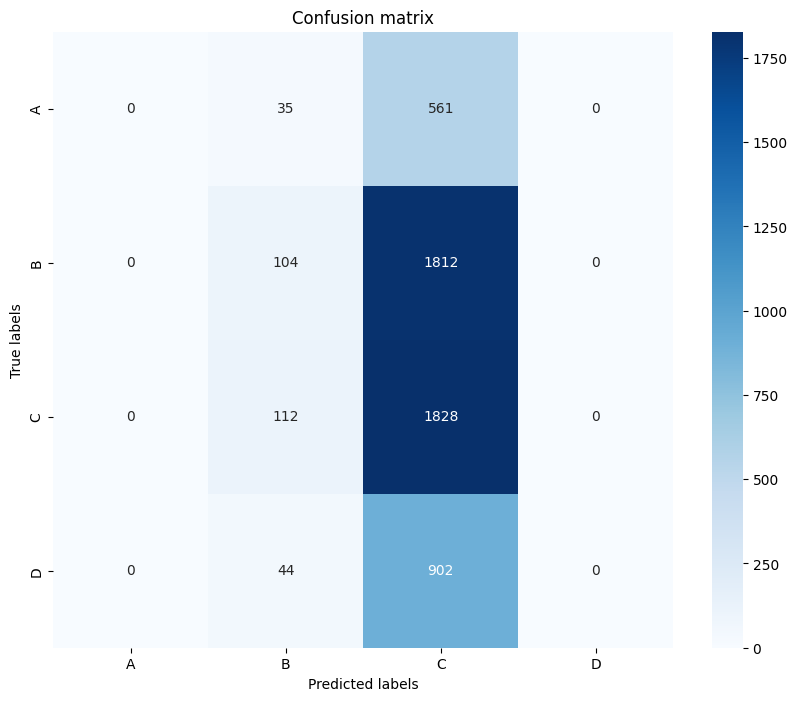


Epoch 2/20
----------


100%|██████████| 10798/10798 [30:36<00:00,  5.88it/s]


train Loss: 1.3142 Acc: 0.3825


100%|██████████| 2699/2699 [02:23<00:00, 18.78it/s]


val Loss: 1.2439 Acc: 0.5031


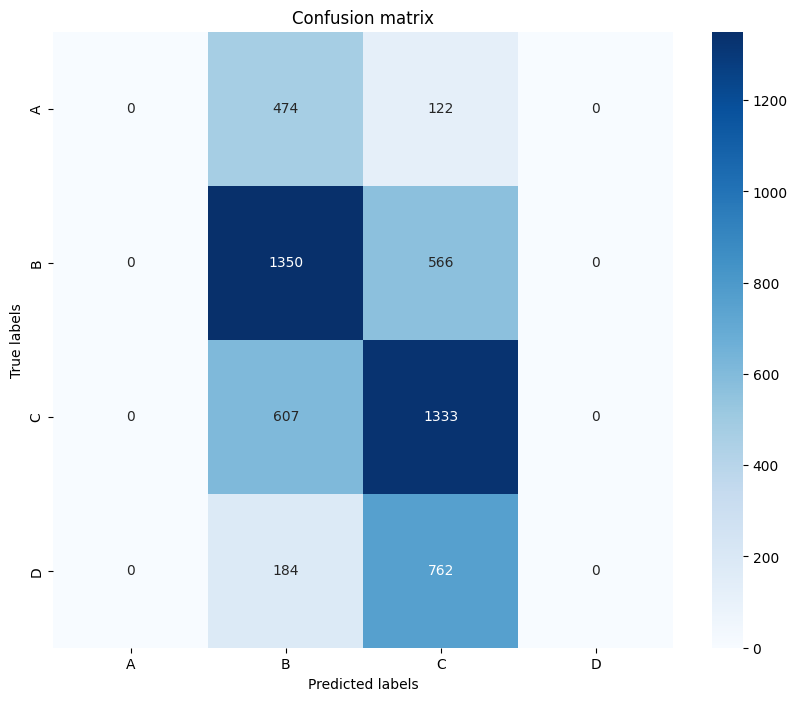


Epoch 3/20
----------


100%|██████████| 10798/10798 [29:55<00:00,  6.01it/s]


train Loss: 1.2594 Acc: 0.4684


100%|██████████| 2699/2699 [02:23<00:00, 18.85it/s]


val Loss: 1.2247 Acc: 0.5206


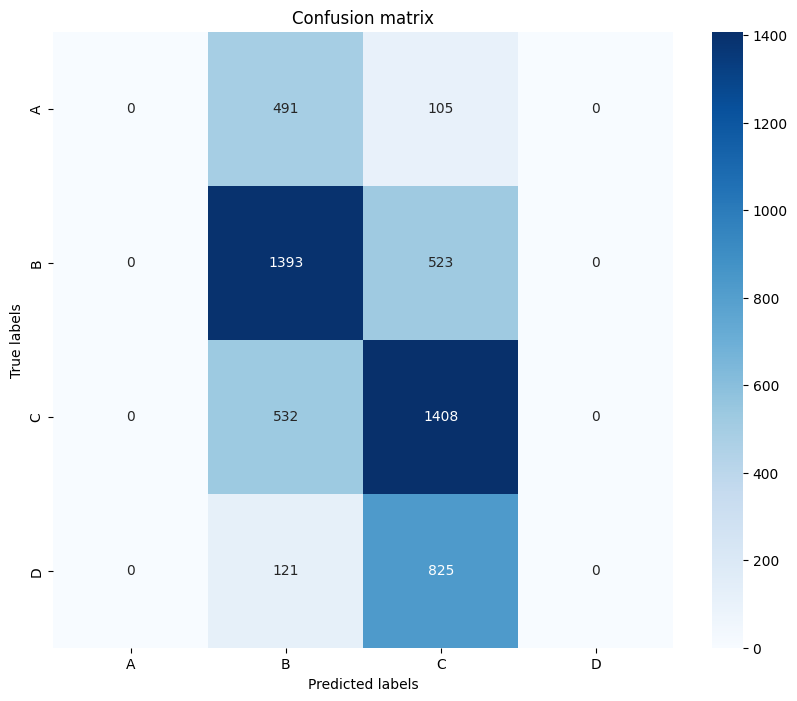


Epoch 4/20
----------


100%|██████████| 10798/10798 [31:16<00:00,  5.75it/s]


train Loss: 1.2192 Acc: 0.5171


100%|██████████| 2699/2699 [02:33<00:00, 17.63it/s]


val Loss: 1.2112 Acc: 0.5246


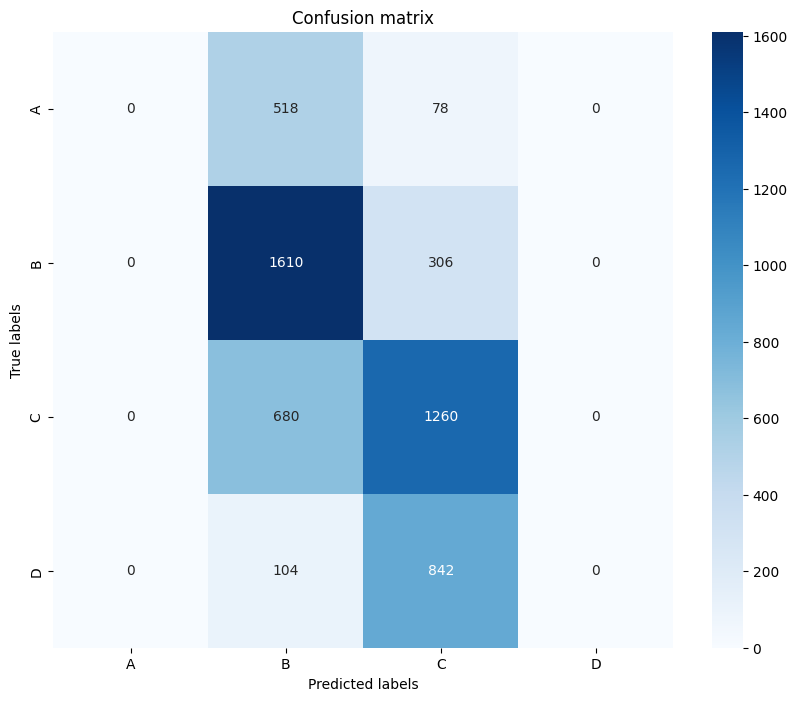


Epoch 5/20
----------


100%|██████████| 10798/10798 [31:49<00:00,  5.65it/s]


train Loss: 1.2077 Acc: 0.5290


100%|██████████| 2699/2699 [02:33<00:00, 17.58it/s]


val Loss: 1.2719 Acc: 0.4537

Epoch 6/20
----------


100%|██████████| 10798/10798 [30:08<00:00,  5.97it/s]


train Loss: 1.2586 Acc: 0.4743


100%|██████████| 2699/2699 [02:36<00:00, 17.29it/s]


val Loss: 1.2726 Acc: 0.4537

Epoch 7/20
----------


100%|██████████| 10798/10798 [30:01<00:00,  6.00it/s]


train Loss: 1.2559 Acc: 0.4759


100%|██████████| 2699/2699 [02:37<00:00, 17.17it/s]


val Loss: 1.2520 Acc: 0.4839

Epoch 8/20
----------


100%|██████████| 10798/10798 [30:01<00:00,  6.00it/s]


train Loss: 1.2530 Acc: 0.4788


100%|██████████| 2699/2699 [02:37<00:00, 17.10it/s]


val Loss: 1.2749 Acc: 0.4537

Epoch 9/20
----------


100%|██████████| 10798/10798 [29:56<00:00,  6.01it/s]


train Loss: 1.2495 Acc: 0.4826


100%|██████████| 2699/2699 [02:21<00:00, 19.05it/s]


val Loss: 1.2455 Acc: 0.4863

Epoch 10/20
----------


100%|██████████| 10798/10798 [30:33<00:00,  5.89it/s]


train Loss: 1.2486 Acc: 0.4846


100%|██████████| 2699/2699 [02:20<00:00, 19.17it/s]


val Loss: 1.2514 Acc: 0.4809

Epoch 11/20
----------


100%|██████████| 10798/10798 [30:25<00:00,  5.91it/s]


train Loss: 1.2421 Acc: 0.4921


100%|██████████| 2699/2699 [02:22<00:00, 18.93it/s]


val Loss: 1.2558 Acc: 0.4744

Epoch 12/20
----------


100%|██████████| 10798/10798 [30:07<00:00,  5.97it/s]


train Loss: 1.2449 Acc: 0.4891


100%|██████████| 2699/2699 [02:35<00:00, 17.35it/s]


val Loss: 1.2403 Acc: 0.4950

Epoch 13/20
----------


100%|██████████| 10798/10798 [29:41<00:00,  6.06it/s]


train Loss: 1.2439 Acc: 0.4904


100%|██████████| 2699/2699 [02:22<00:00, 18.93it/s]


val Loss: 1.2795 Acc: 0.4498

Epoch 14/20
----------


100%|██████████| 10798/10798 [30:18<00:00,  5.94it/s]


train Loss: 1.2442 Acc: 0.4895


100%|██████████| 2699/2699 [02:22<00:00, 18.89it/s]


val Loss: 1.2367 Acc: 0.4993

Epoch 15/20
----------


100%|██████████| 10798/10798 [29:42<00:00,  6.06it/s]


train Loss: 1.2400 Acc: 0.4936


100%|██████████| 2699/2699 [02:22<00:00, 18.89it/s]


val Loss: 1.2706 Acc: 0.4618

Epoch 16/20
----------


100%|██████████| 10798/10798 [29:47<00:00,  6.04it/s]


train Loss: 1.2396 Acc: 0.4956


100%|██████████| 2699/2699 [02:37<00:00, 17.15it/s]


val Loss: 1.2481 Acc: 0.4870

Epoch 17/20
----------


100%|██████████| 10798/10798 [29:39<00:00,  6.07it/s]


train Loss: 1.2407 Acc: 0.4948


100%|██████████| 2699/2699 [02:21<00:00, 19.01it/s]


val Loss: 1.2714 Acc: 0.4591

Epoch 18/20
----------


100%|██████████| 10798/10798 [29:39<00:00,  6.07it/s]


train Loss: 1.2412 Acc: 0.4931


100%|██████████| 2699/2699 [02:21<00:00, 19.03it/s]


val Loss: 1.2341 Acc: 0.5054

Epoch 19/20
----------


100%|██████████| 10798/10798 [29:39<00:00,  6.07it/s]


train Loss: 1.2372 Acc: 0.4958


100%|██████████| 2699/2699 [02:37<00:00, 17.18it/s]


val Loss: 1.2305 Acc: 0.5100

Epoch 20/20
----------


100%|██████████| 10798/10798 [29:49<00:00,  6.03it/s]


train Loss: 1.2421 Acc: 0.4926


100%|██████████| 2699/2699 [02:21<00:00, 19.04it/s]


val Loss: 1.2678 Acc: 0.4607

Training complete in 662m 57s
Best val Acc: 0.524639


In [7]:
for name,model in modeller.items(): 
    model_ft = model
    #model_ft=torch.load('C:/Users/Zeynep Aygün/Desktop/TEKNOFEST/yen/modelPerformance/vit/best_model_0.7244acc_20epochs.h5')
    
    """
    num_ftrs = model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""

    """ num_ftrs=model.heads[-1].in_features
    model_ft.heads[-1]=nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())"""
    
    num_ftrs=model_ft.fc.in_features
    model_ft.fc =nn.Sequential(nn.Linear(num_ftrs, len(class_names)), nn.Softmax())
    
    model_ft = model_ft.to(device)

    criterion = nn.CrossEntropyLoss()

    # Observe that all parameters are being optimized
    #optimizer_ft = optim.SGD(model_ft.parameters(), lr=LEARNING_RATE, momentum=0.9)
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=LEARNING_RATE)

    # Decay LR by a factor of 0.1 every 7 epochs
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=5, gamma=0.0001)

    # TRAINING
    model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, name=name,
                            num_epochs=EPOCH)

In [8]:
import torch
import matplotlib
import numpy as np
import seaborn as sns
from itertools import cycle
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import classification_report

class get_metric():

    def get_accuracy_graph(epochs, train_acc, val_acc):  # draw validation and train accuracy graphs
        plt.plot(epochs, train_acc, color='#006BA4')
        plt.plot(epochs, val_acc, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0.5, 1, 0.05))
        plt.rcParams['figure.figsize'] = (8, 6)
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Accuracy")
        plt.title("Training Accuracy vs Validation Accuracy")
        plt.legend(['Training Acc.', 'Validation Acc.'], loc='lower right')
        plt.show()

    def get_loss_graph(epochs, train_losses, val_losses):  # draw validation and train loss graphs
        matplotlib.rcdefaults()
        plt.plot(epochs, train_losses, color='#006BA4')
        plt.plot(epochs, val_losses, color='#FF800E')
        plt.grid(b=True, which='major', color='lightgray')
        plt.grid(b=True, which='minor', color='lightgray')
        plt.xticks(np.arange(0, 45, 5))
        plt.yticks(np.arange(0, 1.2, 0.2))
        plt.rcParams['figure.dpi'] = 600
        plt.xlabel("Number of Epochs")
        plt.ylabel("Loss")
        plt.title("Training Loss vs Validation Loss")
        plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
        plt.show()

    def test_label_predictions(model, device, test_loader):  # calculate outputs on test dataset for get metrics
        model.eval()
        actuals = []
        predictions = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                model.to(device)
                output = model(data)
                prediction = output.argmax(dim=1, keepdim=True)
                actuals.extend(target.view_as(prediction))
                predictions.extend(prediction)
        return [i.item() for i in actuals], [i.item() for i in predictions]
    
    def test_label_predictions_el2(model_0,model_1,model_2,model_3, device, test_loader):
    
        actuals = []
        predictions = []

        with torch.no_grad():

            for data, target in test_loader:
                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data).cuda().cpu()
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1) :

                        a+=1   
                        if predicted_3[i].item()==0:
                            final_pred[i]=0 

                        if predicted_3[i].item()!=0:
                            final_pred[i]=1                    
                    if a==0:                   
                        final_pred[i]=predicted_2[i] 
                actuals.extend(target.view_as(final_pred))
                predictions.extend(final_pred)
        return [i.item() for i in actuals], [i.item() for i in predictions]

    def test_model(model ,device, test_loader):
        correct = 0
        total = 0
        with torch.no_grad():
            for data in test_loader:
                images, labels = data[0].to(device), data[1].to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))
    
    def test_model_el2(model_0,model_1,model_2,model_3,device, test_loader):
        
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:

                images, labels = data[0].to(device), data[1].to(device)

                outputs_0 = model_0(images)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(images)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(images)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(images)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            final_pred[i]=1

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            final_pred[i]=0                        
                        if predicted_3[i].item()!=0:
                            final_pred[i]=1
                    if a==0:                   
                        final_pred[i]=predicted_2[i]

                total += labels.size(0)
                correct += (final_pred == labels).sum().item()
        print('Correct Prediction: {:d}  Total Images: {:d}'.format(correct, total))
        print('Test Accuracy = {:f}'.format(correct / total))

    def get_classification_report(truth, predict):  # create classification report for each class with scikit-learn library
        print('Classification Report :\n', classification_report(truth, predict))

    def get_confusion_matrix(actuals, predictions):  # create confusion matrix for each class with scikit-learn library
        matplotlib.rcdefaults()
        print('Confusion matrix:\n',confusion_matrix(actuals, predictions))
        cf_matrix=confusion_matrix(actuals, predictions)
        sns.heatmap(cf_matrix, annot=True,fmt='g', cmap='Blues')

    def get_cohen_kappa(actuals, predictions):  # get cohen kapa score for   determine model performance
        cps = cohen_kappa_score(actuals, predictions)
        print('Kappa Score of this model:\n', cps)

    def test_class_probabilities(model, device, test_loader, which_class):
        
        truths = []
        probabilities = []
        with torch.no_grad():
            for data, target in test_loader:
                data, target = data.to(device), target.to(device)
                output = model(data).cuda().cpu()
                prediction = output.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(output[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    def test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, test_loader, which_class):
    
        truths = []
        probabilities = []

        with torch.no_grad():
            for data, target in test_loader:

                data, target = data.to(device), target.to(device)

                outputs_0 = model_0(data)
                _, predicted_0 =torch.max(outputs_0.data, 1) 

                outputs_1 = model_1(data)
                _, predicted_1 =torch.max(outputs_1.data, 1) 

                outputs_2 = model_2(data)
                _, predicted_2 =torch.max(outputs_2.data, 1)

                outputs_3 = model_3(data)
                _, predicted_3 =torch.max(outputs_3.data, 1)

                final_pred=predicted_1
                out=outputs_1
                size=final_pred.size()

                for i in range(0,(size[0])):   
                    a=0              
                    if predicted_2[i].item()==0 and predicted_3[i].item()==0:

                        if predicted_1[i].item()==1:
                            #final_pred[i]=1
                            out[i]=outputs_1[i]

                        if predicted_1[i].item()==0:
                            final_pred[i]=0
                            out[i]=outputs_1[i]
                        a+=1

                    if (predicted_0[i].item()==1 and predicted_1[i].item()==1):

                        a+=1

                        if predicted_3[i].item()==0:
                            #final_pred[i]=0
                            out[i]=outputs_3[i]

                        if predicted_3[i].item()!=0:
                            #final_pred[i]=1
                            out[i]=outputs_3[i]
                    if a==0:                   
                        #final_pred[i]=predicted_2[i]
                        out[i]=outputs_2[i]
                prediction = out.argmax(dim=1, keepdim=True)
                truths.extend(target.view_as(prediction) == which_class)
                probabilities.extend(np.exp(out.cuda().cpu()[:, which_class]))
        return [i.item() for i in truths], [i.item() for i in probabilities]
    
    def get_roc_curves_el2(model_0,model_1,model_2,model_3, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities_el2(model_0,model_1,model_2,model_3, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
            label='ROC curve of class {0} (area = {1:0.4f})'
            ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()

    def get_roc_curves(model, device, data):  # draw Roc curves and calculate auc score for each class
        fpr = dict()
        tpr = dict()
        roc_auc = dict()

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 0)
        fpr[0], tpr[0], _ = roc_curve(actuals, class_probabilities)
        roc_auc[0] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 1)
        fpr[1], tpr[1], _ = roc_curve(actuals, class_probabilities)
        roc_auc[1] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 2)
        fpr[2], tpr[2], _ = roc_curve(actuals, class_probabilities)
        roc_auc[2] = roc_auc_score(actuals, class_probabilities)

        actuals, class_probabilities = get_metric.test_class_probabilities(model, device, data, 3)
        fpr[3], tpr[3], _ = roc_curve(actuals, class_probabilities)
        roc_auc[3] = roc_auc_score(actuals, class_probabilities)

        print("Auc Score For Each Class: ", roc_auc)

        matplotlib.rcdefaults()
        plt.figure()
        colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
        for i, color in zip(range(2), colors):
            plt.plot(fpr[i], tpr[i], color=color, lw=1,
                label='ROC curve of class {0} (area = {1:0.4f})'
                    ''.format(i, roc_auc[i]))
        plt.plot([0, 1], [0, 1], 'k--', lw=1)
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.show()



resnet101
-----------------
F1 Score: 0.0 0.6669428334714168 0.5693628558517849 0.0
Recall: 0.0 0.8402922755741128 0.6494845360824743 0.0
Precision: 0.0 0.5528846153846154 0.5068382944489139 0.0


Classification Report :
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       596
           1       0.55      0.84      0.67      1916
           2       0.51      0.65      0.57      1940
           3       0.00      0.00      0.00       946

    accuracy                           0.53      5398
   macro avg       0.26      0.37      0.31      5398
weighted avg       0.38      0.53      0.44      5398

Correct Prediction: 2870  Total Images: 5398
Test Accuracy = 0.531678
Kappa Score of this model:
 0.27166851371774337


Confusion matrix:
 [[   0  518   78    0]
 [   0 1610  306    0]
 [   0  680 1260    0]
 [   0  104  842    0]]




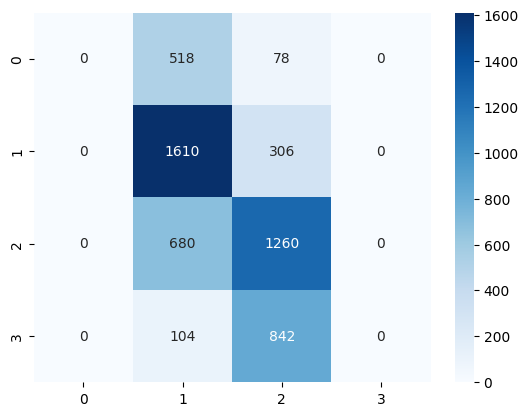

In [10]:
from sklearn.metrics import f1_score,accuracy_score,recall_score,roc_auc_score,roc_curve,confusion_matrix,precision_score,recall_score
print('\n'+'resnet101'+'\n-----------------')  
model_ft=torch.load("C:/Users/Zeynep Aygün/Desktop/teknofest_github/Mergen1-Teknofest/zeynep/modelPerformance/resnet101/best_model_0.5246acc_20epochs.h5")
phase='val'
actuals, predictions = get_metric.test_label_predictions(model_ft, device, dataloaders[phase])
f1=f1_score(predictions,actuals,average=None)
recall=recall_score(actuals,predictions,average=None)
precision=precision_score(actuals,predictions,average=None)
print(f'F1 Score: {f1[0]} {f1[1]} {f1[2]} {f1[3]}')
print(f'Recall: {recall[0]} {recall[1]} {recall[2]} {recall[3]}') 
print(f'Precision: {precision[0]} {precision[1]} {precision[2]} {precision[3]}')
print('\n')
get_metric.get_classification_report(actuals, predictions)
get_metric.test_model(model_ft,device,dataloaders[phase])
get_metric.get_cohen_kappa(actuals, predictions)
print('\n')
get_metric.get_confusion_matrix(actuals, predictions)
print('\n')
#get_metric.get_roc_curves(model_ft, device,  dataloaders[phase])